In [66]:
from mppi import Utilities as U, Parsers as P
import matplotlib.pyplot as plt
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import InsetPosition,inset_axes
import numpy as np
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
import yaml

# Plots

This notebook collects the script for the plots.

## Decay constant from the echo peaks

We measure the physical dephasing time from the height and time position of the echo peaks.

In [134]:
file = 'Results/echo_decay.yaml'
eta = 4e-4

In [135]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'ref', 'time'])

In [136]:
time = np.array(data_loaded['time'])
ref = np.array(data_loaded['ref'])
echo = data_loaded['echo']

for tau in echo:
    echo[tau] = np.array(echo[tau])

In [137]:
echo.keys()

dict_keys(['0.5ps', '0ps', '1.5ps', '1ps', '2.5ps', '2ps'])

We build the expected exponential decay of the polarization, starting from the its peak

In [138]:
ind_max = np.argmax(ref)
pol_peak = ref[ind_max]
time_exp = time[ind_max:]
exp_decay = pol_peak*np.exp(-eta*(time_exp-time_exp[0]))

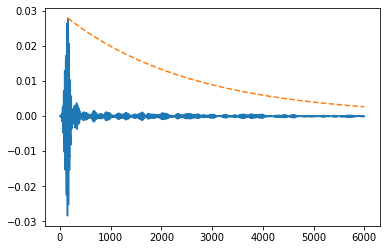

In [139]:
plt.plot(time,ref)
plt.plot(time_exp,exp_decay,linestyle='--')

We perform the exponential fit of the echo peaks.

We do not include the signal due to the echo pulse the starts at t=0. We compute the time postions at the 
echo peaks and we fit the associated curve with an single exponential decay

In [140]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']

In [167]:
time_peak = []
signal_peak = []
for t in tau:
    time_peak.append(time[np.argmax(echo[t])])
    signal_peak.append(max(echo[t]))
t0 = time_peak[0]
time_fit = time[np.where(time == t0)[0][0]:]

In [168]:
signal_peak

[9.16570748970522e-05,
 5.688687976579995e-05,
 3.825820530477677e-05,
 2.557306779672351e-05,
 1.7559662331048902e-05]

In [169]:
def monoExp(t, x0):
    return x0*np.exp(-eta*(t-t0))

In [170]:
p0 = (1.5e-4) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(monoExp, time_peak, signal_peak, p0)
x0 = params[0]
x0

8.861098997430812e-05

In [171]:
exp_fit = monoExp(time_fit,x0)

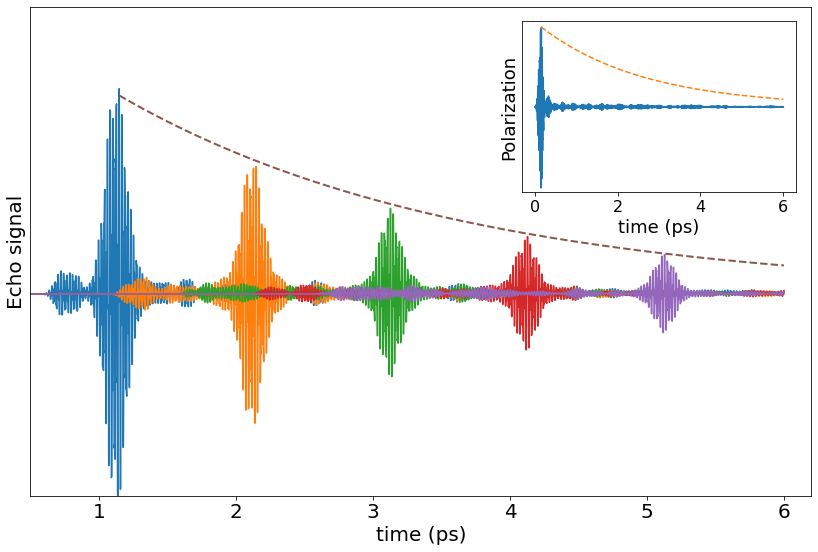

In [182]:
label_size = 20
label_size_inset = 18
e_min = min(echo['0.5ps'])*1.
e_max = max(echo['0.5ps'])*1.4

fig, ax1 = plt.subplots(figsize=(14, 9))

for t in tau:
    ax1.plot(time*1e-3,echo[t],label='echo_'+t)
ax1.plot(time_fit*1e-3,exp_fit,linestyle='--',linewidth=2)
#ax1.scatter(np.array(time_peak)*1e-3,signal_peak,linewidth=4)
#for tm in time_peak:
#    ax1.axvline(tm*1e-3,ymax=(monoExp(tm,x0)-e_min)/(e_max-e_min),color='black',ls='--') #
ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_xlim(0.5,6.2)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([])
ax1.tick_params(axis='both', which='major', labelsize=label_size)

ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.63,0.62,0.35,0.35])
ax2.set_axes_locator(ip)
ax2.plot(time*1e-3,ref)
ax2.plot(time_exp*1e-3,exp_decay,linestyle='--')
ax2.set_yticks([])
ax2.set_ylim(-0.03,0.03)
ax2.set_xlabel('time (ps)',size=label_size_inset)
ax2.set_ylabel('Polarization',size=label_size_inset)
ax2.tick_params(axis='both', which='major', labelsize=16)

#plt.savefig(fname='Plot/echo_decay.eps',format='eps',bbox_inches = "tight")

## Analysis of the echo peaks (without physical decay time)

We analyze the shape of the echo peaks in function of $\tau$ when no decay time is included in the computation.

This analysis is useful to assess the efficiency of the echo signal retrieval and to compare the numerical results with
the ones derived from the analytical perturbation theory

In [3]:
file = 'Results/echo_no_decay.yaml'

In [180]:
with open(file, 'r') as f:
    data_loaded = yaml.safe_load(f)
data_loaded.keys()

dict_keys(['echo', 'profile', 'ref', 'time', 'time_output'])

We choose the values of $\tau$ reported in the plot and sorted in the correct order

In [181]:
tau = ['0.5ps','1ps','1.5ps','2ps','2.5ps']
echo_peak_vals = [1e3,2e3,3e3,4e3,5e3]

In [182]:
time = np.array(data_loaded['time'])
time_output = np.array(data_loaded['time_output'])
ref = np.array(data_loaded['ref'])
echo = data_loaded['echo']
profile = data_loaded['profile']

for t in tau:
    echo[t] = np.array(echo[t])
    profile[t] = np.array(profile[t])

We rescale the echo and the profile arrays, so that the maximum is set to 1

In [183]:
echo_max = max(echo[tau[0]])
profile_max = max(profile[tau[0]])
for t in tau:
    echo[t] = echo[t]/echo_max
    profile[t] = profile[t]/profile_max

We rescale the first peak of the profile for better plot visualization

In [204]:
ind_rescale = np.where(time_output > 400)[0][0]
rescale_profile = np.zeros([len(time_output)])
rescale_profile[:ind_rescale] = 1
rescale_profile[ind_rescale:] = 3
rescale_profile

array([1., 1., 1., ..., 3., 3., 3.])

We compute the maximum of the profile of the echo pulse

In [193]:
tmax_profile = {}
for t in tau:
    signal = profile[t]
    ind_max = argrelextrema(signal,np.greater,order=2)[0][1]
    tmax_profile[t] = time_output[ind_max]
tmax_profile

{'0.5ps': 629.0,
 '1ps': 1127.0,
 '1.5ps': 1629.0,
 '2ps': 2127.0,
 '2.5ps': 2629.0}

In [194]:
times_profile = 1e-3*np.array([tmax_profile[i] for i in tau])
times_profile

array([0.629, 1.127, 1.629, 2.127, 2.629])

We define a procedure that perform a gaussian fit of the echo signal

In [195]:
def gauss(x,a,x0,sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [196]:
gauss_pars = {}

for t,p in zip(tau,echo_peak_vals):
    signal = echo[t]
    # build the envelope of the signal
    ind_max = argrelextrema(signal,np.greater,order=2)[0]
    values_env = signal[ind_max]
    time_env = time[ind_max]
    # perform the fit
    mean = p
    sigma = 100
    popt,pcov = curve_fit(gaus,time_env,values_env,p0=[1,mean,sigma])
    gauss_pars[t] = popt
gauss_pars

{'0.5ps': array([9.48296701e-01, 1.12995143e+03, 7.98787604e+01]),
 '1ps': array([8.38015142e-01, 2.12323364e+03, 8.71167562e+01]),
 '1.5ps': array([7.54289773e-01, 3.13173452e+03, 9.13577954e+01]),
 '2ps': array([7.19010071e-01, 4.12113905e+03, 9.25905847e+01]),
 '2.5ps': array([7.41656896e-01, 5.12704470e+03, 8.58911356e+01])}

In [197]:
times_echo = 1e-3*np.array([gauss_pars[t][1] for t in tau])
times_echo

array([1.12995143, 2.12323364, 3.13173452, 4.12113905, 5.1270447 ])

We can compute the distance between the max of the profile of the echo pulse and mean time (according to a gaussian fit)
of the echo pulse

In [198]:
for t in tau:
    diffe = gauss_pars[t][1]-tmax_profile[t]
    print(t,diffe)

0.5ps 500.9514268914761
1ps 996.2336357694858
1.5ps 1502.7345166545351
2ps 1994.1390489806936
2.5ps 2498.044696887985


This computation shows that the echo peak is realized as expected and the shift w.r.t. the nominal time is due to the finite
size of the pulse

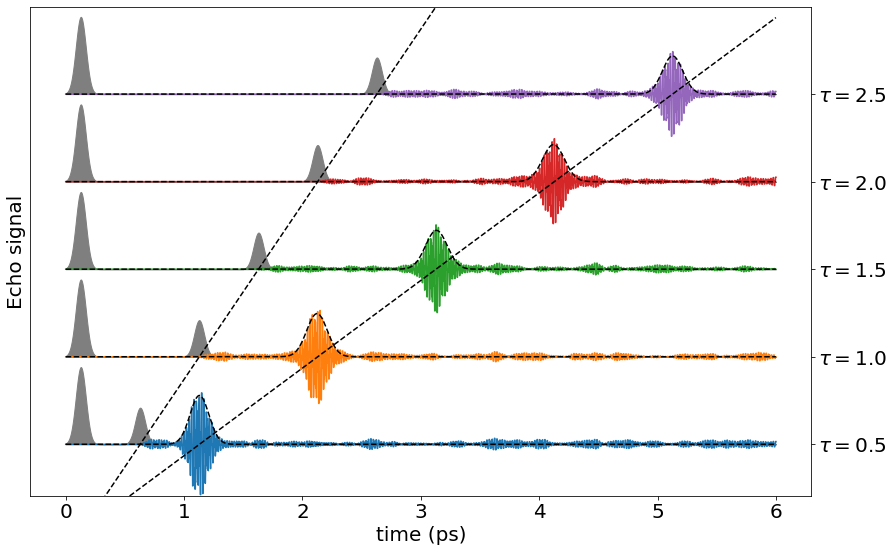

In [215]:
tau_disp = [r'$\tau=0.5$',r'$\tau=1.0$',r'$\tau=1.5$',r'$\tau=2.0$',r'$\tau=2.5$']
label_size = 20
e_min = -1
e_max = 8.5
shift = 1.7
a_profile = 4*shift/(times_profile[-1]-times_profile[0])
b_profile = -a*times_profile[0]
a_echo = 4*shift/(times_echo[-1]-times_echo[0])
b_echo = -a_echo*times_echo[0]

ypos=0

fig, ax1 = plt.subplots(figsize=(14, 9))

for t in tau:
    ax1.plot(time*1e-3,ypos+echo[t]) #,color='tab:orange'
    #ax1.plot(time_output*1e-3,ypos+1.5*profile[t],color='tab:grey')
    ax1.fill_between(time_output*1e-3,ypos+1.5*profile[t]*rescale_profile,ypos,color='tab:grey')
    ax1.plot(time*1e-3,ypos+gauss(time,*gauss_pars[t]),color='black',linestyle='--')
    ypos+=shift
ax1.plot(time*1e-3,a_profile*time*1e-3+b_profile,color='black',linestyle='--')
#ax1.scatter(times_profile,a_profile*times_profile+b_profile,color='black')
ax1.plot(time*1e-3,a_echo*time*1e-3+b_echo,color='black',linestyle='--')
#ax1.scatter(times_echo,a_echo*times_echo+b_echo)

ax1.set_xlabel('time (ps)',size=label_size)
ax1.set_ylabel('Echo signal',size=label_size)
ax1.set_ylim(e_min,e_max)
ax1.set_yticks([shift*i for i in range(len(tau_disp))])
ax1.set_yticklabels(tau_disp,size=label_size)
ax1.yaxis.tick_right()
ax1.tick_params(axis='both', which='major', labelsize=label_size)

#plt.savefig(fname='Plot/echo_analysis.eps',format='eps',bbox_inches = "tight")

In [170]:
# the shape is consistent with a delay 2*tau
a_echo/a_profile

0.5003636054761731

Lastly we compute the ratio between the area of the first peak and the areas of the echo peaks.
We use the gaussian fit to compute the areas

In [227]:
signal = ref
# build the envelope of the signal
ind_max = argrelextrema(signal,np.greater,order=2)[0]
values_env = signal[ind_max]
time_env = time[ind_max]
# perform the fit
mean = 130
sigma = 100
gauss_pars_ref,pcov = curve_fit(gaus,time_env,values_env,p0=[1,mean,sigma])
gauss_pars_ref

array([2.64497706e-02, 1.49103954e+02, 4.37069522e+01])

In [229]:
def theta(pars):
    return np.sqrt(2*np.pi)*pars[0]*pars[2]

In [234]:
area_ref = theta(gauss_pars_ref)
print('area ref',area_ref)
for t in tau:
    area = echo_max*theta(gauss_pars[t])
    ratio = area/theta_ref
    print(t,area,ratio)

area ref 2.8977596965451995
0.5ps 0.024996534808109542 0.00862615862796049
1ps 0.024091165618192974 0.008313720991742421
1.5ps 0.022739875433066496 0.00784739861630959
2ps 0.02196878564846379 0.007581300021066505
2.5ps 0.02102110952751481 0.007254262509267707


the ratio is about 8e-3 and decrease in function of $\tau$. Maybe is due to the small dephasing included in the
computation? To be checked....

We observe that the width of the first peak is about 44 ps (comparable with the one of the pulse
of about 42 ps), while the echo peaks are broader, with widths between 80 and 90 ps